In [1]:
!pip install transformers datasets -q

In [2]:
!pip install rouge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import os

In [ ]:
import json
import os

# File paths
gnd_subjects_file = "/content/drive/MyDrive/nlp_project_data/GND-Subjects-all.json"
tibkat_dev_dir = "/content/drive/MyDrive/nlp_project_data/dev"

# Function to load GND subjects
def load_gnd_subjects(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        gnd_data = json.load(f)

    # Assuming that 'Code' is the key for subject IDs and 'Name' is the key for subject names
    subjects = {item['Code']: item['Name'] for item in gnd_data}

    return subjects

# Function to extract abstract and subject from a jsonid file
def extract_abstract_and_subject(jsonid_file):
    with open(jsonid_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    data = data.get("@graph", [])[-1]

    # Extract the abstract and dcterms:subject (assuming these are the keys)
    abstract = data.get('abstract', '')
    dcterms_subjects = data.get('dcterms:subject', [])

    return abstract, dcterms_subjects

# Function to process the TIBKAT dev directory and match subjects
def process_tibkat_directory(tibkat_dev_dir, gnd_subjects):
    # Dictionary to store file-based results
    file_based_results = {}

    # Iterate over the directory structure for each category
    for category in ['Article', 'Book', 'Conference', 'Report', 'Thesis']:
        category_path = os.path.join(tibkat_dev_dir, category, 'en')

        if os.path.exists(category_path):
            print(category_path)
            for file_name in os.listdir(category_path):
                if file_name.endswith('.jsonld'):
                    jsonid_file = os.path.join(category_path, file_name)

                    # Extract the abstract and subjects
                    abstract, dcterms_subjects = extract_abstract_and_subject(jsonid_file)

                    file_subjects = []
                    # Check if any of the dcterms:subject match with GND subjects
                    if isinstance(dcterms_subjects, list):
                        for subject_id in dcterms_subjects:
                            subject = subject_id.get("@id", "")
                            # Match the subject with GND 'Code'
                            if subject in gnd_subjects:
                                file_subjects.append(gnd_subjects[subject])  # Append subject name, not ID
                    else:
                        subject = dcterms_subjects.get("@id", "")
                        # Match the subject with GND 'Code'
                        if subject in gnd_subjects:
                            file_subjects.append(gnd_subjects[subject])  # Append subject name, not ID

                    file_based_results[os.path.join(category, 'en', file_name)] = {
                        'abstract': abstract,
                        'subject': file_subjects,
                        'category': category
                    }

    return file_based_results

# Load GND subjects
gnd_subjects = load_gnd_subjects(gnd_subjects_file)

# Process the TIBKAT dev directory to find matching subjects
file_based_results = process_tibkat_directory(tibkat_dev_dir, gnd_subjects)

# Optionally save the results to a file (uncomment below lines if needed)
output_file = "/content/drive/MyDrive/nlp_project_data/processed_data.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(file_based_results, f, ensure_ascii=False, indent=4)

print(f"Results saved to {output_file}")


/content/drive/MyDrive/nlp_project_data/dev/Article/en
/content/drive/MyDrive/nlp_project_data/dev/Book/en
/content/drive/MyDrive/nlp_project_data/dev/Conference/en
/content/drive/MyDrive/nlp_project_data/dev/Report/en
/content/drive/MyDrive/nlp_project_data/dev/Thesis/en
Results saved to /content/drive/MyDrive/nlp_project_data/processed_data.json


In [4]:
import json
from datasets import Dataset

# Load the data (assuming the results are stored in the JSON file)
with open("/content/drive/MyDrive/nlp_project_data/processed_data.json", "r", encoding="utf-8") as f:
    results = json.load(f)

data = []
for file_path, details in results.items():
    # Extract the input (abstract)
    input_text = details.get('abstract', '')
    if isinstance(input_text, list):
        input_text = ". ".join(input_text)

    # Extract and join subjects into a single string
    subjects = details.get('subject', [])

    output_text = ', '.join(subjects)

    # Add validated entry
    data.append({'input': input_text, 'output': output_text})


# Create a dataset
if data:  # Ensure data is non-empty
    dataset = Dataset.from_dict({
        "input": [entry['input'] for entry in data],
        "output": [entry['output'] for entry in data]
    })
else:
    raise ValueError("No valid data to create the dataset.")


In [5]:
dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 2081
})

In [6]:
from transformers import T5Tokenizer

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenize the dataset
def tokenize_function(examples):
    # T5 expects the input to be formatted as "task: input_text"
    inputs = [f"tagging: {text}" for text in examples["input"]]
    targets = examples["output"]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/2081 [00:00<?, ? examples/s]

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
import torch
import os
import torch
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from sklearn.metrics import f1_score
from rouge import Rouge
import time

# Check if GPU is available and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)  # Move model to GPU

checkpoint_dir = "/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/t5_model_output"

# Find the latest checkpoint
def find_latest_checkpoint(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]
    if not checkpoints:
        return None
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[1]))
    return os.path.join(checkpoint_dir, latest_checkpoint)

latest_checkpoint = find_latest_checkpoint(checkpoint_dir)

# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/t5_model_output",  # Output directory for model checkpoints
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Reduce batch size if memory issues arise
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision for faster training on T4 GPUs
    save_strategy="epoch",  # Save model at each epoch
    logging_dir="/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/logs",  # Logging directory
    logging_steps=50,  # Adjust as needed
    resume_from_checkpoint=latest_checkpoint if latest_checkpoint else None,
)

def compute_performance_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # F1 Score (using exact match as a simple baseline)
    f1 = f1_score([1 if pred == label else 0 for pred, label in zip(decoded_preds, decoded_labels)],
                  [1] * len(decoded_preds),
                  average='binary')

    # Semantic Matching using ROUGE
    rouge = Rouge()
    rouge_scores = rouge.get_scores(decoded_preds, decoded_labels, avg=True)
    semantic_accuracy = rouge_scores['rouge-l']['f']

    # Computational Efficiency Metrics
    start_time = time.time()
    # Simulate inference on a batch
    batch_size = 16
    sample_inputs = tokenizer(decoded_preds[:batch_size], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        _ = model.generate(**sample_inputs, max_length=50)
    inference_time = time.time() - start_time

    # Memory usage
    memory_allocated = torch.cuda.memory_allocated(device) / (1024 * 1024)  # in MB

    return {
        'f1_score': f1,
        'semantic_accuracy': semantic_accuracy,
        'inference_batch_time': inference_time,
        'memory_allocated_mb': memory_allocated
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,  # Use a validation set if available
    compute_metrics=compute_performance_metrics
)

# Train the model
trainer.train()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: i211700 (i211700-fast). Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


In [ ]:
# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/fine_tuned_t5_model_v2")
tokenizer.save_pretrained("/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/fine_tuned_t5_model_v2")

In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/fine_tuned_t5_model_v2"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)


In [12]:
# Ensure the model is on the same device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Function to test the model on a single abstract
def generate_subjects(abstract):
    # Preprocess the input
    input_text = f"tagging: {abstract}"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

    # Generate predictions
    outputs = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)

    # Decode the output
    generated_subjects = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_subjects

# Example abstract for testing
test_abstract = "With the growing reliance on renewable energy sources such as wind and solar, power grid operators face unprecedented challenges in ensuring stability and reliability. This paper explores advanced machine learning techniques, including reinforcement learning and neural networks, to optimize energy distribution in smart grids. The study integrates historical weather data, energy consumption patterns, and grid topology to predict demand surges and adjust supply in real-time. Additionally, it examines the use of blockchain for decentralized energy trading, ensuring transparency and security. The findings highlight significant improvements in grid efficiency and reduction in carbon emissions, paving the way for sustainable energy management systems."

# Generate subjects
predicted_subjects = generate_subjects(test_abstract)
print("Abstract:", test_abstract)
print("Predicted Subjects:", predicted_subjects)

Abstract: With the growing reliance on renewable energy sources such as wind and solar, power grid operators face unprecedented challenges in ensuring stability and reliability. This paper explores advanced machine learning techniques, including reinforcement learning and neural networks, to optimize energy distribution in smart grids. The study integrates historical weather data, energy consumption patterns, and grid topology to predict demand surges and adjust supply in real-time. Additionally, it examines the use of blockchain for decentralized energy trading, ensuring transparency and security. The findings highlight significant improvements in grid efficiency and reduction in carbon emissions, paving the way for sustainable energy management systems.
Predicted Subjects: Elektrizität, Stromversorgung, Stromversorgung


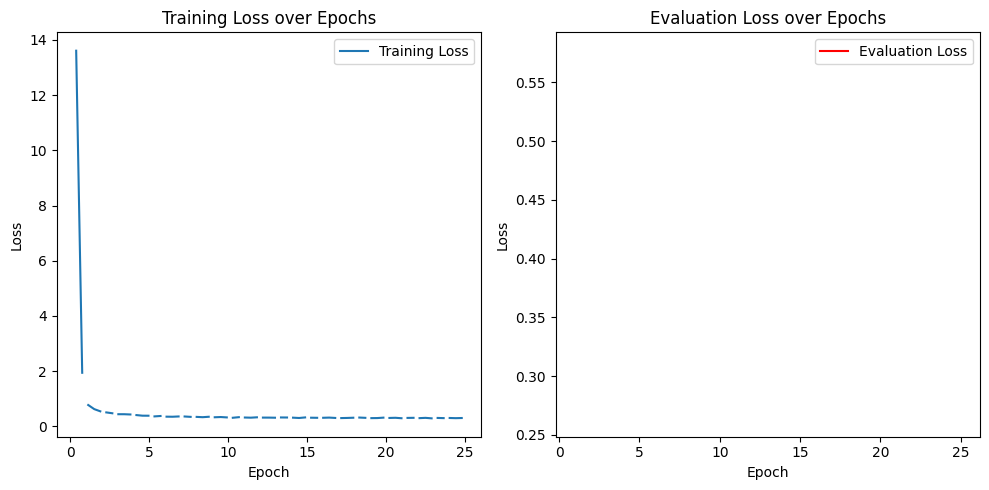

Training Summary:
loss: [13.6075, 1.9438, nan, 0.7764, 0.6274, 0.5483, nan, 0.5086, 0.4775, nan, 0.4429, 0.4425, 0.4334, nan, 0.4114, 0.3899, 0.3887, nan, 0.3641, 0.3783, nan, 0.3542, 0.3517, 0.3616, nan, 0.3603, 0.3472, nan, 0.3459, 0.3354, 0.3506, nan, 0.3326, 0.3408, 0.3275, nan, 0.3148, 0.3355, nan, 0.3232, 0.3178, 0.3308, nan, 0.3205, 0.3201, 0.3162, nan, 0.3256, 0.3237, nan, 0.3178, 0.3065, 0.3263, nan, 0.3162, 0.3132, nan, 0.3141, 0.3206, 0.3082, nan, 0.3033, 0.3082, 0.3157, nan, 0.322, 0.312, nan, 0.3013, 0.3037, 0.3187, nan, 0.3077, 0.3136, 0.2976, nan, 0.3092, 0.3123, nan, 0.3012, 0.3112, 0.2936, nan, 0.3082, 0.3017, nan, 0.3063, 0.3001, 0.3054, nan, nan]
eval_loss: [nan, nan, 0.5769282579421997, nan, nan, nan, 0.4402593970298767, nan, nan, 0.37987229228019714, nan, nan, nan, 0.34005147218704224, nan, nan, nan, 0.3168869614601135, nan, nan, 0.30388474464416504, nan, nan, nan, 0.2979676425457001, nan, nan, 0.29254981875419617, nan, nan, nan, 0.288296103477478, nan, nan, nan, 0

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the training history
training_history = trainer.state.log_history

# Convert to DataFrame for easier manipulation
history_df = pd.DataFrame(training_history)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot evaluation metrics (if available)
plt.subplot(1, 2, 2)
if 'eval_loss' in history_df.columns:
    plt.plot(history_df['epoch'], history_df['eval_loss'], label='Evaluation Loss', color='red')
    plt.title('Evaluation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

# If you want to save the plot
plt.savefig('/content/drive/MyDrive/nlp_project_data/model_t5_small_v1/training_evaluation_plot.png')

# Print out key metrics
print("Training Summary:")
for column in history_df.columns:
    if 'loss' in column or 'metric' in column:
        print(f"{column}: {history_df[column].tolist()}")

In [ ]:
import os
os.kill(os.getpid(), 9)